In [1]:
import tensorflow as tf 
import numpy as np 
import gym

In [2]:
env = gym.make('CartPole-v0')
env = env.unwrapped
env.seed(1)

[1]

In [3]:
obs_space = 4
act_space = env.action_space.n

max_eps = 1000
l_rate = 0.01
gamma = 0.95

In [4]:
def disc_norm_rewards(ep_rewards):
    disc_ep_rewards = np.zeros_like(ep_rewards)
    cum = 0.0
    for i in reversed(range(len(ep_rewards))):
        cum = ep_rewards[i] + gamma * cum
        disc_ep_rewards[i] = cum
    
    mean = np.mean(disc_ep_rewards)
    std = np.std(disc_ep_rewards)
    disc_ep_rewards = (disc_ep_rewards - mean) / std
    
    return disc_ep_rewards

In [5]:
state_in = tf.placeholder(tf.float32, [None, obs_space], name = 'st_in')
action_in = tf.placeholder(tf.float32, [None, act_space], name = 'ac_in')
disc_ep_rewards_in = tf.placeholder(tf.float32, [None,], name = 'disc_r_in')

#Policy

fc1 = tf.layers.dense(state_in, 10, activation = tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer())
fc2 = tf.layers.dense(fc1, act_space, activation = tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer())
fc3 = tf.layers.dense(fc2, act_space, activation = None, kernel_initializer = tf.contrib.layers.xavier_initializer())

'''
with tf.name_scope("fc1"):
    fc1 = tf.contrib.layers.fully_connected(inputs = state_in,
                                            num_outputs = 10,
                                            activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer())

with tf.name_scope("fc2"):
    fc2 = tf.contrib.layers.fully_connected(inputs = fc1,
                                            num_outputs = act_space,
                                            activation_fn= tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer())
    
with tf.name_scope("fc3"):
    fc3 = tf.contrib.layers.fully_connected(inputs = fc2,
                                            num_outputs = act_space,
                                            activation_fn= None,
                                            weights_initializer=tf.contrib.layers.xavier_initializer())
'''

action_distribution = tf.nn.softmax(fc3)

#Loss 
neg_log_probs = - tf.reduce_sum(tf.math.multiply(action_in, tf.log(action_distribution)), axis = -1)
loss = tf.reduce_mean(neg_log_probs * disc_ep_rewards_in)

#Optimizer 
opt = tf.train.AdamOptimizer(l_rate).minimize(loss)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
all_rewards = []
total_rewards = 0
maxReward = 0
ep = 0
ep_states, ep_actions, ep_rewards = [], [], []

saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for ep in range(max_eps):
    ep_reward_sum = 0
    
    state = env.reset()
    
    #env.render()
    while True:
        
        #Choose action a from the output probability distribution
        action_prob_distribution = sess.run(action_distribution, feed_dict = {state_in : state.reshape([1, 4])})
        action = np.random.choice(range(action_prob_distribution.shape[1]), p = action_prob_distribution.ravel())
        
        #perform a
        new_state, reward, done, info = env.step(action)
        
        #Store a, s, r
        ep_states.append(state)
        ep_rewards.append(reward)
        
        a = np.zeros(act_space)
        a[action] = 1
        ep_actions.append(a)
        
        if done:
            ep_rewards_sum = np.sum(ep_rewards)
            all_rewards.append(ep_rewards_sum)
            total_rewards = np.sum(all_rewards)
            mean_reward = np.divide(total_rewards, ep + 1)
            maxReward = np.amax(all_rewards)
            
            
            print("==========================================")
            print("Episode: ", ep)
            print("Reward: ", ep_rewards_sum)
            print("Mean Reward", mean_reward)
            print("Max reward so far: ", maxReward)
            
            #Discounted return
            disc_ep_rewards = disc_norm_rewards(ep_rewards)
            
            _loss, _ = sess.run([loss, opt], feed_dict = {state_in : np.vstack(np.array(ep_states)),
                                                          action_in : np.vstack(np.array(ep_actions)),
                                                          disc_ep_rewards_in : disc_ep_rewards})
                                
            ep_states, ep_actions, ep_rewards = [], [], []
            break
            
        state = new_state
    #Save model
    if ep % 10 == 0:
        saver.save(sess, './models/model.ckpt')
        print('Model saved')

Episode:  0
Reward:  17.0
Mean Reward 17.0
Max reward so far:  17.0
Model saved
Episode:  1
Reward:  24.0
Mean Reward 20.5
Max reward so far:  24.0
Episode:  2
Reward:  11.0
Mean Reward 17.333333333333332
Max reward so far:  24.0
Episode:  3
Reward:  9.0
Mean Reward 15.25
Max reward so far:  24.0
Episode:  4
Reward:  15.0
Mean Reward 15.2
Max reward so far:  24.0
Episode:  5
Reward:  10.0
Mean Reward 14.333333333333334
Max reward so far:  24.0
Episode:  6
Reward:  27.0
Mean Reward 16.142857142857142
Max reward so far:  27.0
Episode:  7
Reward:  12.0
Mean Reward 15.625
Max reward so far:  27.0
Episode:  8
Reward:  60.0
Mean Reward 20.555555555555557
Max reward so far:  60.0
Episode:  9
Reward:  47.0
Mean Reward 23.2
Max reward so far:  60.0
Episode:  10
Reward:  12.0
Mean Reward 22.181818181818183
Max reward so far:  60.0
Model saved
Episode:  11
Reward:  14.0
Mean Reward 21.5
Max reward so far:  60.0
Episode:  12
Reward:  19.0
Mean Reward 21.307692307692307
Max reward so far:  60.0
Epi

Episode:  70
Reward:  19.0
Mean Reward 23.6056338028169
Max reward so far:  81.0
Model saved
Episode:  71
Reward:  31.0
Mean Reward 23.708333333333332
Max reward so far:  81.0
Episode:  72
Reward:  48.0
Mean Reward 24.041095890410958
Max reward so far:  81.0
Episode:  73
Reward:  25.0
Mean Reward 24.054054054054053
Max reward so far:  81.0
Episode:  74
Reward:  29.0
Mean Reward 24.12
Max reward so far:  81.0
Episode:  75
Reward:  11.0
Mean Reward 23.94736842105263
Max reward so far:  81.0
Episode:  76
Reward:  19.0
Mean Reward 23.883116883116884
Max reward so far:  81.0
Episode:  77
Reward:  49.0
Mean Reward 24.205128205128204
Max reward so far:  81.0
Episode:  78
Reward:  19.0
Mean Reward 24.139240506329113
Max reward so far:  81.0
Episode:  79
Reward:  14.0
Mean Reward 24.0125
Max reward so far:  81.0
Episode:  80
Reward:  16.0
Mean Reward 23.91358024691358
Max reward so far:  81.0
Model saved
Episode:  81
Reward:  16.0
Mean Reward 23.817073170731707
Max reward so far:  81.0
Episode:

Episode:  136
Reward:  27.0
Mean Reward 27.0
Max reward so far:  139.0
Episode:  137
Reward:  11.0
Mean Reward 26.884057971014492
Max reward so far:  139.0
Episode:  138
Reward:  19.0
Mean Reward 26.827338129496404
Max reward so far:  139.0
Episode:  139
Reward:  27.0
Mean Reward 26.82857142857143
Max reward so far:  139.0
Episode:  140
Reward:  126.0
Mean Reward 27.53191489361702
Max reward so far:  139.0
Model saved
Episode:  141
Reward:  22.0
Mean Reward 27.492957746478872
Max reward so far:  139.0
Episode:  142
Reward:  39.0
Mean Reward 27.573426573426573
Max reward so far:  139.0
Episode:  143
Reward:  11.0
Mean Reward 27.458333333333332
Max reward so far:  139.0
Episode:  144
Reward:  36.0
Mean Reward 27.517241379310345
Max reward so far:  139.0
Episode:  145
Reward:  18.0
Mean Reward 27.45205479452055
Max reward so far:  139.0
Episode:  146
Reward:  17.0
Mean Reward 27.38095238095238
Max reward so far:  139.0
Episode:  147
Reward:  19.0
Mean Reward 27.324324324324323
Max reward 

Model saved
Episode:  201
Reward:  37.0
Mean Reward 32.198019801980195
Max reward so far:  139.0
Episode:  202
Reward:  15.0
Mean Reward 32.11330049261084
Max reward so far:  139.0
Episode:  203
Reward:  14.0
Mean Reward 32.02450980392157
Max reward so far:  139.0
Episode:  204
Reward:  73.0
Mean Reward 32.22439024390244
Max reward so far:  139.0
Episode:  205
Reward:  88.0
Mean Reward 32.49514563106796
Max reward so far:  139.0
Episode:  206
Reward:  124.0
Mean Reward 32.93719806763285
Max reward so far:  139.0
Episode:  207
Reward:  134.0
Mean Reward 33.42307692307692
Max reward so far:  139.0
Episode:  208
Reward:  46.0
Mean Reward 33.483253588516746
Max reward so far:  139.0
Episode:  209
Reward:  125.0
Mean Reward 33.91904761904762
Max reward so far:  139.0
Episode:  210
Reward:  46.0
Mean Reward 33.976303317535546
Max reward so far:  139.0
Model saved
Episode:  211
Reward:  21.0
Mean Reward 33.91509433962264
Max reward so far:  139.0
Episode:  212
Reward:  36.0
Mean Reward 33.924

Episode:  267
Reward:  170.0
Mean Reward 47.026119402985074
Max reward so far:  272.0
Episode:  268
Reward:  225.0
Mean Reward 47.687732342007436
Max reward so far:  272.0
Episode:  269
Reward:  151.0
Mean Reward 48.07037037037037
Max reward so far:  272.0
Episode:  270
Reward:  128.0
Mean Reward 48.36531365313653
Max reward so far:  272.0
Model saved
Episode:  271
Reward:  209.0
Mean Reward 48.955882352941174
Max reward so far:  272.0
Episode:  272
Reward:  139.0
Mean Reward 49.285714285714285
Max reward so far:  272.0
Episode:  273
Reward:  157.0
Mean Reward 49.67883211678832
Max reward so far:  272.0
Episode:  274
Reward:  18.0
Mean Reward 49.56363636363636
Max reward so far:  272.0
Episode:  275
Reward:  208.0
Mean Reward 50.13768115942029
Max reward so far:  272.0
Episode:  276
Reward:  16.0
Mean Reward 50.014440433213
Max reward so far:  272.0
Episode:  277
Reward:  444.0
Mean Reward 51.431654676258994
Max reward so far:  444.0
Episode:  278
Reward:  198.0
Mean Reward 51.95698924

Model saved
Episode:  331
Reward:  313.0
Mean Reward 81.76204819277109
Max reward so far:  789.0
Episode:  332
Reward:  98.0
Mean Reward 81.8108108108108
Max reward so far:  789.0
Episode:  333
Reward:  217.0
Mean Reward 82.21556886227545
Max reward so far:  789.0
Episode:  334
Reward:  696.0
Mean Reward 84.04776119402985
Max reward so far:  789.0
Episode:  335
Reward:  751.0
Mean Reward 86.0327380952381
Max reward so far:  789.0
Episode:  336
Reward:  315.0
Mean Reward 86.71216617210682
Max reward so far:  789.0
Episode:  337
Reward:  213.0
Mean Reward 87.08579881656804
Max reward so far:  789.0
Episode:  338
Reward:  526.0
Mean Reward 88.38053097345133
Max reward so far:  789.0
Episode:  339
Reward:  337.0
Mean Reward 89.11176470588235
Max reward so far:  789.0
Episode:  340
Reward:  396.0
Mean Reward 90.0117302052786
Max reward so far:  789.0
Model saved
Episode:  341
Reward:  472.0
Mean Reward 91.12865497076024
Max reward so far:  789.0
Episode:  342
Reward:  376.0
Mean Reward 91.9

Episode:  394
Reward:  144.0
Mean Reward 246.99746835443037
Max reward so far:  24047.0
Episode:  395
Reward:  108.0
Mean Reward 246.64646464646464
Max reward so far:  24047.0
Episode:  396
Reward:  106.0
Mean Reward 246.29219143576827
Max reward so far:  24047.0
Episode:  397
Reward:  110.0
Mean Reward 245.9497487437186
Max reward so far:  24047.0
Episode:  398
Reward:  64.0
Mean Reward 245.4937343358396
Max reward so far:  24047.0
Episode:  399
Reward:  33.0
Mean Reward 244.9625
Max reward so far:  24047.0
Episode:  400
Reward:  86.0
Mean Reward 244.5660847880299
Max reward so far:  24047.0
Model saved
Episode:  401
Reward:  69.0
Mean Reward 244.12935323383084
Max reward so far:  24047.0
Episode:  402
Reward:  66.0
Mean Reward 243.68734491315138
Max reward so far:  24047.0
Episode:  403
Reward:  45.0
Mean Reward 243.19554455445544
Max reward so far:  24047.0
Episode:  404
Reward:  113.0
Mean Reward 242.8740740740741
Max reward so far:  24047.0
Episode:  405
Reward:  124.0
Mean Reward

KeyboardInterrupt: 

In [7]:
from matplotlib import pyplot as plt

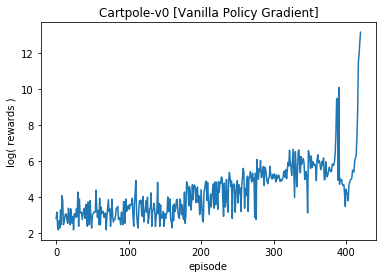

In [16]:
plt.xlabel('episode')
plt.ylabel('log( rewards )')
plt.title('Cartpole-v0 [Vanilla Policy Gradient]')
plt.plot(np.log(np.array(all_rewards)))